# 可视化演示：掩码自编码器（MAE）
在本Notebook中，我们将可视化一个基于非常简单的目标（即掩码块预测）进行预训练的视觉变换器（ViT）的部分预测结果。该模型需要为被遮罩的图像块重建像素值.

原论文:https://arxiv.org/abs/2111.06377

原始代码仓库: https://github.com/facebookresearch/mae

# 图像预处理
此处我们应用了基础的图像处理技术，具体包括将图像尺寸调整为224x224像素，并对各颜色通道进行归一化处理。

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/mindnlp/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated. Please use ViTImageProcessor instead.
  warnings.warn(


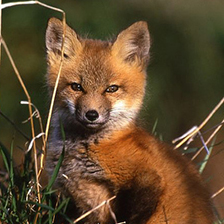

In [5]:
# 需要 GPU 或Ascend 资源下运行案例代码，不然运行速度很慢且可能看不到生成效果
from mindnlp.core import nn, ops
from mindnlp.transformers import ViTFeatureExtractor, ViTMAEForPreTraining
import requests
import mindspore as ms
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [6]:
pixel_values = feature_extractor(image, return_tensors="ms").pixel_values

# 可视化解析
随后，我们将像素值输入模型进行前向传递。编码器（采用标准视觉Transformer架构）会首先对视觉块进行特征编码。在掩码块位置处加入可学习的掩码标记后，解码器（同样采用Transformer架构）基于已编码的视觉块特征和掩码标记，执行像素值的重建任务。

研究团队通过实验发现，当对图像块进行高比例掩码（75%）时，模型展现出最优性能表现

In [7]:
from mindnlp.core import nn, ops
from mindnlp.transformers import ViTFeatureExtractor, ViTMAEForPreTraining
import numpy as np
import matplotlib.pyplot as plt


imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def visualize(pixel_values, model):

    total_params = sum(p.size for p in model.get_parameters())  # 使用MindSpore的参数统计方式
    outputs = model(pixel_values)
    
    logits = outputs.logits
    logits_np = logits.asnumpy()

    
    mask = outputs.mask
    mask_np = mask.asnumpy()

    y = model.unpatchify(logits)
    y_nhwc = ops.einsum('nchw->nhwc', y)[0].asnumpy()

    expanded_mask = mask.unsqueeze(-1)
    expanded_mask_np = expanded_mask.asnumpy()

    tiled_mask = ops.tile(mask.unsqueeze(-1), (1, 1, 3*(16**2))) 
    tiled_mask_np = tiled_mask.asnumpy()
  
    
    unpatched_mask = model.unpatchify(tiled_mask)
    unpatched_mask_np = unpatched_mask.asnumpy()
    
    mask_nhwc = ops.einsum('nchw->nhwc', unpatched_mask)[0].asnumpy()
    x_nhwc = ops.einsum('nchw->nhwc', pixel_values)[0].asnumpy()


    im_masked = x_nhwc * (1 - mask_nhwc)
    im_paste = im_masked + y_nhwc * mask_nhwc

    def denorm(tensor):
        return np.clip((tensor * imagenet_std + imagenet_mean) * 255, 0, 255)
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(1, 4, 1)
    plt.imshow(denorm(x_nhwc)/255)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(denorm(im_masked)/255)
    plt.title("Masked")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(denorm(y_nhwc)/255)
    plt.title("Reconstruction")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(denorm(im_paste)/255)
    plt.title("Reconstruction + Visible")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


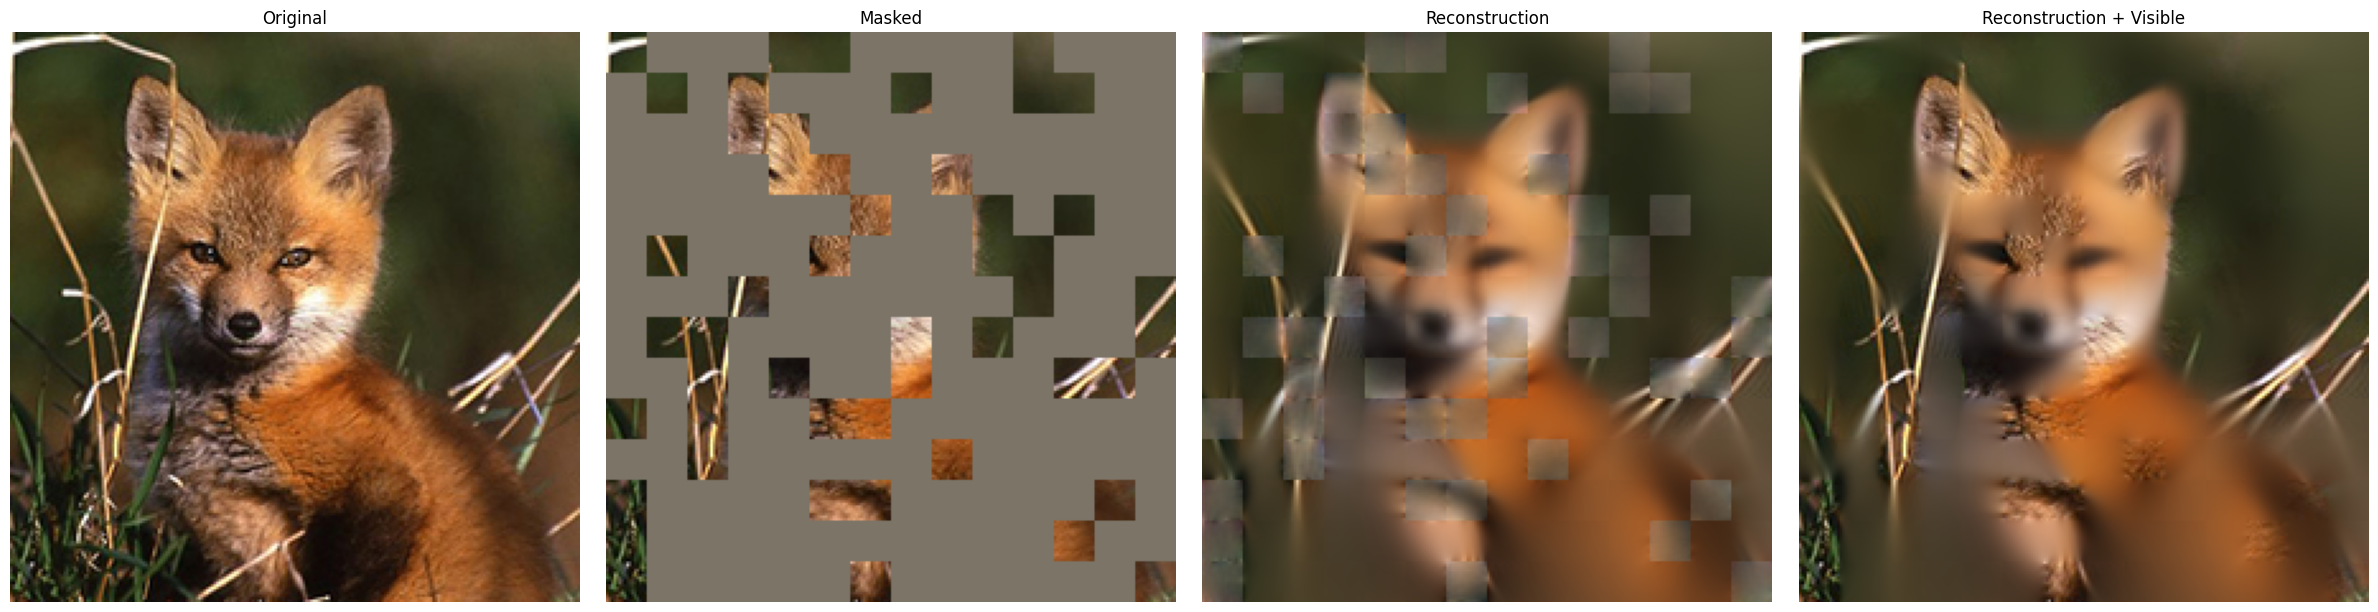

In [8]:
from mindnlp.transformers import ViTFeatureExtractor, ViTMAEForPreTraining

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)